**Install packages**

In [ ]:
# Package for ggplot2 enhancements
install.packages("ggExtra")

# Package for multivariate normal distribution
install.packages('mvtnorm')

**Load essential libraries**

In [16]:
library(ggplot2) # library for plotting
library(dplyr) # library for data wrangling
library(ggExtra) # library for enhanced ggplot2 plots
library(mvtnorm) # library for multivariate normal distribution
library(tidyr) # library to reorganize data

In [17]:
# Load RData file data2.RData
load(url('https://tinyurl.com/527nxn23'))
str(data2)

List of 3
 $ X   : num [1:1000, 1:11] 6.65 -5.63 9.72 -4.64 -12.84 ...
 $ Xval: num [1:100, 1:11] 18.27 -3.19 -5.26 12.95 3.76 ...
 $ yval: num [1:100, 1] 1 0 0 1 0 0 0 0 0 0 ...
 - attr(*, "header")=List of 3
  ..$ description: chr "MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 23:12:48 2011                                                "
  ..$ version    : chr "5"
  ..$ endian     : chr "little"


In [18]:
# Training data
X_train = data2$X # training data as matrix (all samples here are non-anomalous)
df_train = as.data.frame(X_train) # training data frame
head(X_train, n = 5)

6.653114,13.689702,17.552845,-11.933497,-5.756409,15.435921,-12.1367520,8.2241226,-4.8840241,5.3493353,17.351372352
-5.630542,-18.937667,18.644624,-6.155825,-25.988864,15.409553,-16.5955163,9.4546537,-2.8771734,-6.0094204,19.210636116
9.721525,-9.982489,15.571434,-32.224266,-5.595799,24.321383,0.8327735,10.7945546,0.7275748,10.3929750,7.085994903
-4.635766,-10.716040,20.356571,-9.002097,-4.920569,-4.261957,-1.3058288,0.9499803,-8.6341066,0.1984454,0.006771413
-12.841044,-20.388313,9.491936,-7.038500,-9.921087,-3.716105,-9.3847304,-2.3255336,-13.5185624,11.0070290,14.003210283


In [19]:
# Validation data
X_validate = data2$Xval # validation data as matrix
y_validate = data2$yval # validation data labels
df_validate = as.data.frame(X_validate) # validation data frame
head(y_validate, n = 5) # 1 represents an outlier sample, 0 represents a regular sample

1
0
0
1
0


In [20]:
# Fraction of servers that are outliers in the validation set
mean(y_validate == 1)  # supervised algorithms have to address such class imbalance

[1] 0.1

In [21]:
# Wide to long dataframe containing training data
df_gather_train = gather(as.data.frame(X_train))
colnames(df_gather_train) = c('Variable', 'Value')
head(df_gather_train, n = 5)

,Variable,Value
,<chr>,<dbl>
1,V1,6.653114
2,V1,-5.630542
3,V1,9.721525
4,V1,-4.635766
5,V1,-12.841044


In [22]:
# Wide to long dataframe containing validation data
df_gather_validate = gather(as.data.frame(X_validate))
colnames(df_gather_validate) = c('Variable', 'Value')
head(df_gather_validate, n = 5)

,Variable,Value
,<chr>,<dbl>
1,V1,18.271283
2,V1,-3.193070
3,V1,-5.256678
4,V1,12.953176
5,V1,3.763819


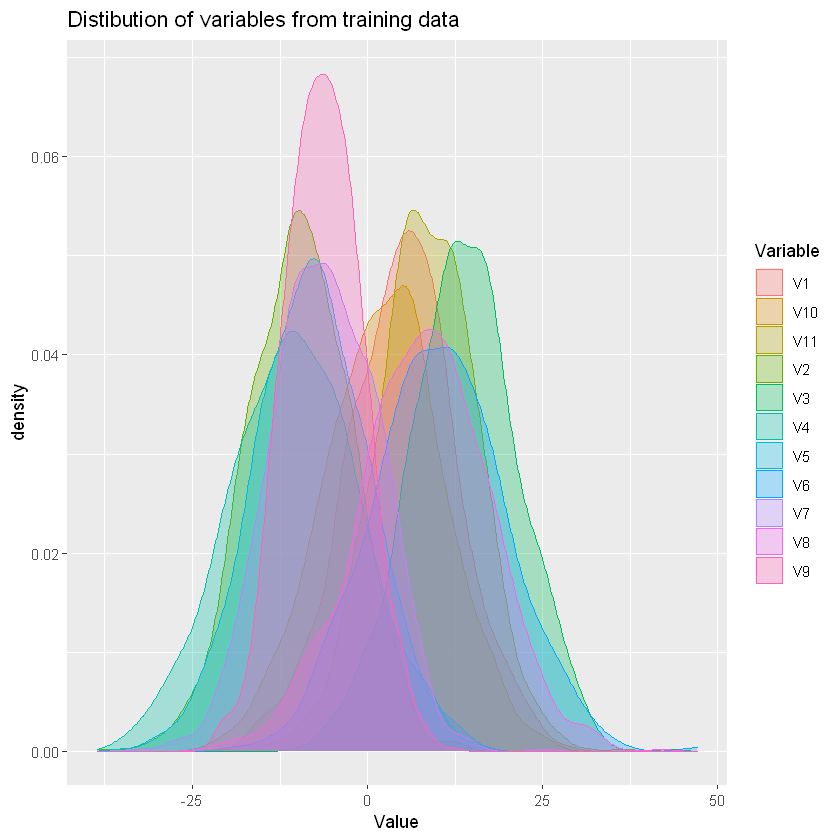

In [23]:
# Separate density plots for each variable (or features) in the training data
df_gather_train %>% ggplot(aes(x = Value, fill = Variable, color = Variable)) +
geom_density(alpha = 0.3)+ggtitle('Distibution of variables from training data')

# Which variable appears the least normally disributed?

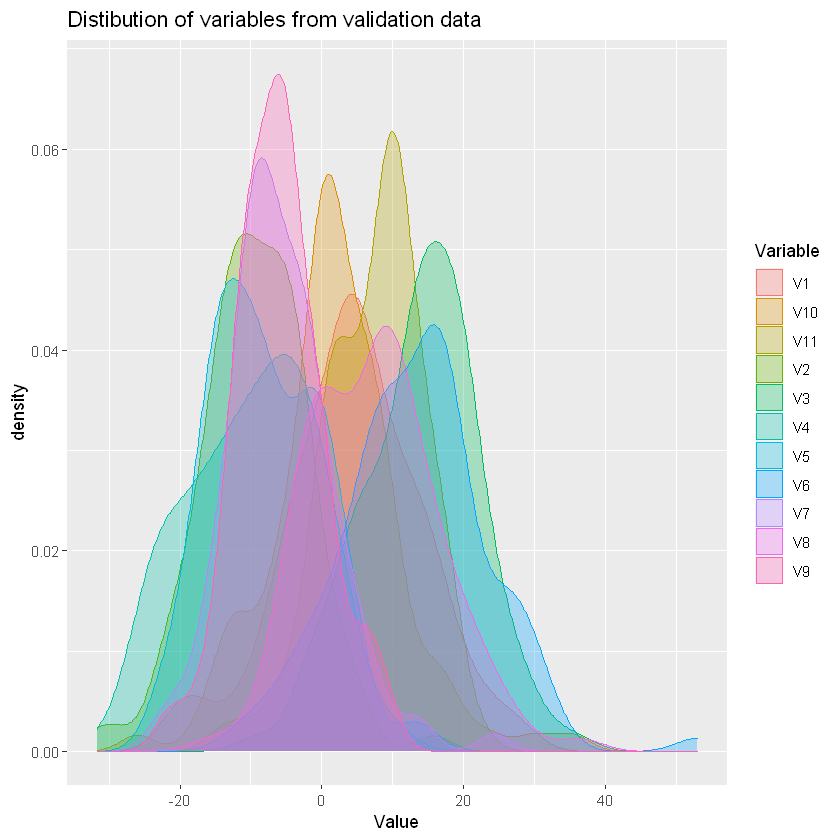

In [24]:
# Separate density plots for each variable (or features) in the validation data
df_gather_validate %>% ggplot(aes(x = Value, fill = Variable, color = Variable)) +
geom_density(alpha = 0.3)+ggtitle('Distibution of variables from validation data')

# Which variable appears the least normally disributed?

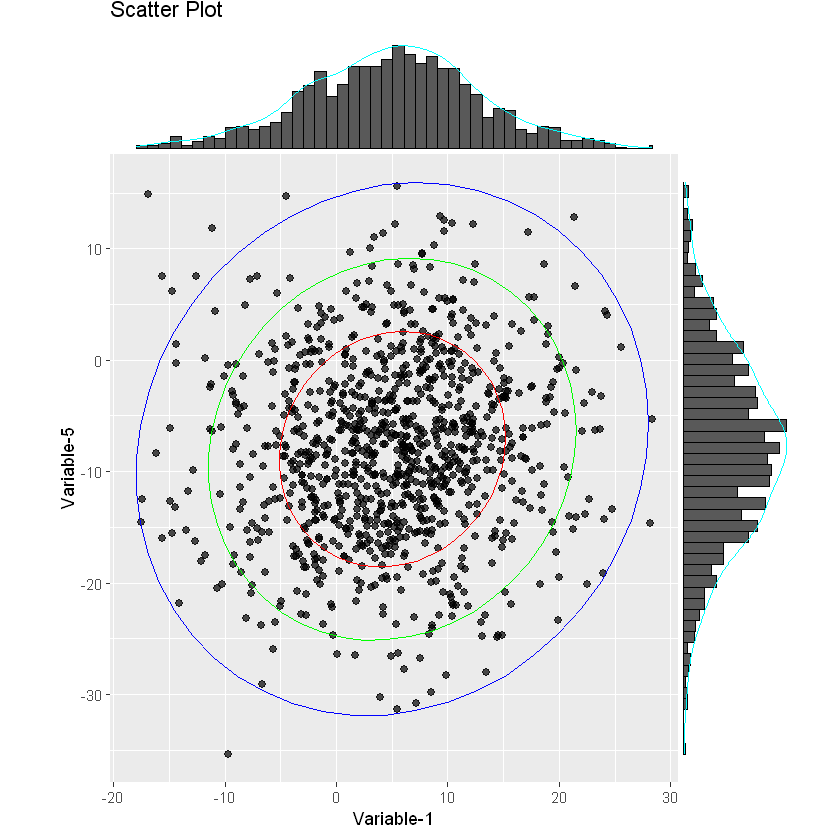

In [25]:
# Make a scatter plot with the marginal densities for any pair of variables
# in the training data

p1 = ggplot(data = df_train, aes(x = V1, y = V5)) + 
geom_point(size = 2, alpha = 0.7) + xlab("Variable-1") + 
   ylab("Variable-5") + ggtitle("Scatter Plot") +
   coord_fixed(ratio = 1) +
   stat_ellipse(level = 0.68, color = 'red')+
   stat_ellipse(level = 0.95, color = 'green')+
   stat_ellipse(level = 0.997, color = 'blue')

# Add marginal histogram plot to the scatter plot 
delta =1
ggMarginal(p1, type = 'histogram', color = 'black', binwidth = delta)

# Add marginal density plot to the scatter plot
ggMarginal(p1, type = 'density', color = 'cyan')

In [33]:
solve(cov(as.data.frame(cbind(X_train, 2*X_train[, 11]))))
#solve(cov(as.data.frame(cbind(X_train, 2*X_train[, 11]))))

ERROR: Error in solve.default(cov(as.data.frame(cbind(X_train, 2 * X_train[, : system is computationally singular: reciprocal condition number = 1.32631e-17


In [37]:
## Build model using training data 
mu_train = colMeans(X_train) # sample mean using training data
S_train = cov(as.data.frame(X_train)) # sample covariance matrix using training data
S_train_inverse = solve(S_train)  # inverse of sample covariance matrix from training data

# Mahalanobis distance of training samples
M_distance_train = apply(X_train, 1, function(x){sqrt(t(x-mu_train) %*% S_train_inverse %*% (x-mu_train))})

# Mahalanobis distance of validation samples using model built using training data
M_distance_validate = apply(X_validate, 1, function(x){sqrt(t(x-mu_train) %*% S_train_inverse %*% (x-mu_train))})

# Add Mahalanobis distance as new column of training and validation data frame
df_train$MD = M_distance_train
df_validate$MD = M_distance_validate

head(df_validate)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,MD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,18.271283,-12.359268,5.000970,1.611472,1.088592,29.314410,-8.313531,36.4383382,-9.4766787,-25.9281827,7.108628,5.673373
2,-3.193070,-19.705821,6.528556,-21.570858,3.050556,23.477503,-1.133420,12.6884094,-10.9683011,-1.1986661,1.908441,3.517914
3,-5.256678,-12.918720,25.435141,-7.231568,3.647838,12.366550,-6.512076,8.7509021,-0.7687545,-3.2610945,13.729474,2.911051
4,12.953176,-10.350333,19.857858,-24.424608,3.266105,30.445294,-11.125842,12.8156288,9.3513545,-6.1136236,17.627375,4.592003
5,3.763819,-5.728187,11.400169,-17.555297,-6.246576,16.155969,-9.724758,16.9966156,-5.1686543,0.1879945,11.401234,1.613877
6,-8.701132,-5.139959,21.404200,-18.084270,-9.109825,6.903168,-3.486003,0.2738549,-7.5489155,9.0570309,2.890973,2.807131


In [38]:
k = ncol(X_train)
qchisq(0.9,k)

[1] 17.27501

In [ ]:
## Determine cutoff probability such that we get the best performance on the validation set
## Best performance corresponds to, for example, the best F1 score (close to 1)

# Add a new column to training and validation data frame for outliers
k = ncol(X_train) # dimensions or the number of features
j = 1 # vary this to change cutoff probability
cutoff_probability = 1-(10^(-j))
threshold = qchisq(?, ?) # threshold for Mahalanobis distance
df_train$Outliers = ((?)^2 >= threshold)
df_validate$Outliers = ((df_validate$MD)^2 >= ?)

# True positives
tp = sum((df_validate$Outliers == 'TRUE') & (y_validate == 1))
# False positives
fp = sum((df_validate$Outliers == 'TRUE') & (y_validate == 0))
# False negatives
fn = sum((df_validate$Outliers == 'FALSE') & (y_validate == 1))
# Precision
precision = tp / (tp + fp)
# Recall
recall = tp / (tp + fn)
# F1 score
F1 = (2 * precision * recall) / (precision + recall)
cat(sprintf('Threshold = %f\n', threshold))
cat(sprintf('For probability cutoff = %f, \nPrecision = %f,\nRecall = %f,\nF1 score = %f,\nFraction of outliers in training data = %f\n', cutoff_probability, precision, recall, F1,mean(df_train$Outliers == 'TRUE')))